In [1]:
using Plots, LinearAlgebra, Statistics, BenchmarkTools
using HermiteGF
using SparseArrays

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$

- [Vlasov Equation - Wikipedia](https://en.wikipedia.org/wiki/Vlasov_equation)

In [2]:
nx = 64
matrix = spdiagm(-1 => ones(Float64,nx-2),
                  0 => -2*ones(Float64,nx),
                  1 => ones(Float64,nx-2))

typeof(matrix)

SparseMatrixCSC{Float64,Int64}

In [3]:
struct UniformMesh
    nx :: Int64
    dx :: Float64
    x  :: Vector{Float64}
    function UniformMesh( xmin, xmax, nx)
        dx = (xmax - xmin)/ nx
        x = range(xmin, stop=xmax, length=nx+1)[1:end-1]
        new( nx, dx, x)
    end
end

In [8]:
struct ChebyshevMesh
    nx :: Int64
    x  :: Vector{Float64}
    dx :: Vector{Float64}
    function ChebyshevMesh( nodes::HermiteGF.NodesType)
        dx =[ x1 - x0 for (x1,x0) in zip(nodes.xk[2:end],nodes[1:end-1]) ]
        x = nodes.xk
        new( nx, dx, x)
    end
end

In [10]:
using FINUFFT

In [15]:
# nonuniform data
nj = 100
x = cos.(pi*(0:nj)/nj)
c = zeros(ComplexF64, nj+1)
c .= sin.(2π*x)
tol = 1e-10 # Tolerance
fk = nufft1d1(x, c, 1, tol, nj+1)


101-element Array{Complex{Float64},1}:
   5.584753414241665e-14 - 0.35097512906531686im
  2.2769049240487975e-14 + 0.3460622760686021im 
  1.4418950171021002e-14 + 0.7592282400803025im 
  1.6725892838437951e-16 + 0.47820095427679987im
  6.6916272059536776e-15 - 0.27625072461281613im
  1.3990616035404268e-14 - 0.819554565084303im  
  1.0975440705747361e-14 - 0.6205962915571777im 
  2.0567056387383178e-15 + 0.18407393606094397im
 -1.1002718884819555e-14 + 0.8724100155922695im 
  -1.803102988082452e-14 + 0.7797996795596343im 
 -2.4896187230081736e-14 - 0.06523024357720061im
   -2.90312440695184e-14 - 0.9151155022376986im 
 -4.0357654933700227e-14 - 0.958086699003012im  
                         ⋮                      
   -2.90312440695184e-14 + 0.9151155022376986im 
 -2.5054838597278428e-14 + 0.06523024357720138im
  -2.085953639957866e-14 - 0.7797996795596365im 
 -1.1002718884819555e-14 - 0.8724100155922695im 
   7.475423910489307e-16 - 0.18407393606094238im
  1.0991984334477415e-14 + 0.6

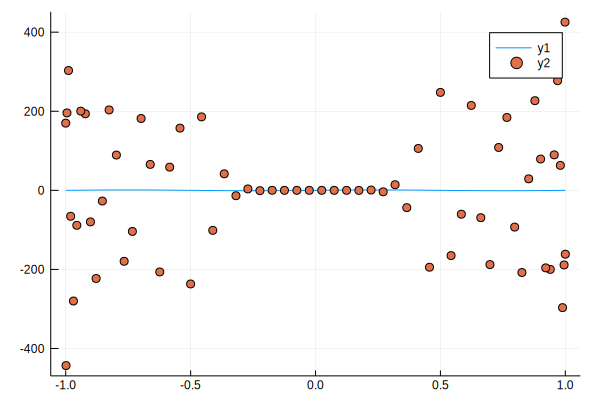

In [81]:
using FastTransforms
using LinearAlgebra
using Random
using FFTW

nj = 64

tol = 1e-15
xmin, xmax = -1, 1
x = cos.(π*(0:nj-1)/(nj-1))
#x = collect(range(xmin, stop= xmax, length=nj+1)[1:end-1])
f = complex(4π^2 * sin.(2π*x))
start, stop = -1, 1
modes  = zeros(Float64, nj)
modes .= collect(vcat(0:nj÷2-1,-nj÷2:-1) * 2π / (xmax - xmin))
modes[1] = 1.0

xn = 0.5 .+ 0.5 * x # normalization

c = fft(f)
#c = fft(f)
c = c ./ modes.^2
u = inufft2(c, xn, tol)
#u = ifft(c)
plot( x, sin.(2π*x))
scatter!( x, real(u))

$$
Y_k = \sum_{j=0}^{n-1} X_j e^{-2\pi jk \sqrt{-1} / n}
$$

$$
Y_k = \sum_{j=0}^{n-1} X_j e^{2\pi jk \sqrt{-1} / n}
$$

nonuniform fast Fourier transform of type II:

$$
f_j = \sum_{k=0}^{N-1} c_k e^{-2\pi{\rm i} x_j k},\quad{\rm for}\quad 0 \le j \le N-1.
$$

┌ Info: Recompiling stale cache file /Users/navaro/.julia/compiled/v1.0/FastTransforms/5Lm8s.ji for FastTransforms [057dd010-8810-581a-b7be-e3fc3b93f78c]
└ @ Base loading.jl:1187


  0.002726 seconds (6 allocations: 156.484 KiB)
  0.002134 seconds (6 allocations: 156.484 KiB)
  0.081164 seconds (6 allocations: 156.484 KiB)


$$
f_i'' \approx \frac{2 \Big[ f_{i+1}
- \big(1+\frac{h_i}{h_{i-1}}\big) f_i
+\frac{h_i}{h_{i-1}}f_{i-1} 
 \Big]}
{ h_i h_{i-1} (1+\frac{h_i}{h_{i-1}})}
$$

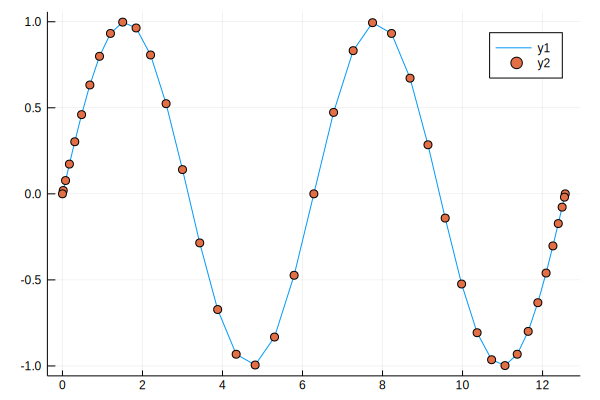

In [7]:
struct ChebyshevPoisson
    x  :: Vector{Float64}
    D2 :: Array{Float64, 2}
    function ChebyshevPoisson( xmin, xmax, nx )
        @assert( isodd(nx) )
        N = nx-1
        x = zeros(Float64, N+1)
        x .= xmin .+ (0.5 .+ 0.5 * cos.(pi*(0:N)/N)) * (xmax - xmin)
        c = ones(N+1) 
        c[1] = 2
        c[end] = 2
        c[2:2:end-1] = -c[2:2:end-1]
        dx = x .- transpose(x)
        dx .+= Matrix{Float64}(I, N+1,N+1)
        D = c ./ transpose(c) 
        D = D ./ dx 
        D = D - Diagonal(vec(sum(D,dims=2)))
        D2 = zeros(Float64,(N-1,N-1))
        D2 .= -(D*D)[2:end-1,2:end-1]
        new( x, D2)
    end      
end

function(p::ChebyshevPoisson)(f::Vector{Float64})
    @assert (length(f) == length(p.x))
    [f[1]; p.D2 \ f[2:end-1]; f[end]]
end

xmin, xmax, nx = 0., 4π, 41
poisson = ChebyshevPoisson(xmin, xmax, nx)
x = poisson.x
f = sin.(x)
u = poisson(f)
plot( x, sin.(x) )
scatter!( x, u)

In [10]:
struct Poisson
    
    nx     :: Int64
    dx     :: Float64
    Φ      :: Array{Float64,1}
    matrix :: SparseMatrixCSC{Float64,Int64}
    
    function Poisson( meshx )
        nx = meshx.nx
        dx = meshx.dx
        Φ  = zeros(Float64,nx)
        matrix = spdiagm(-1 => -ones(Float64,nx-2),
                          0 => +2*ones(Float64,nx),
                          1 => -ones(Float64,nx-2))
        new( nx, dx, Φ, matrix)

    end
  
end

In [10]:
function (p::Poisson)( rho::Array{Float64,1} )
    p.Φ .= p.matrix \  rho
    (circshift(p.Φ, 1) - circshift(p.Φ, -1)) ./ (2*p.dx)
end  

In [11]:
"""
Compute charge density
ρ(x,t) = ∫ f(x,v,t) dv
"""
function compute_rho(meshv::UniformMesh, 
        f::Array{Complex{Float64},2})
    
   dv = meshv.dx
   rho = dv * vec(sum(real(f), dims=2))
   rho .- mean(rho)
end

compute_rho

# Landau Damping

[Landau damping - Wikipedia](https://en.wikipedia.org/wiki/Landau_damping)

In [12]:
function landau(tf::Float64, nt::Int64)
    
  nx, nv = 128, 256
  xmin, xmax = 0.0, 4*pi
  vmin, vmax = -6., 6.
  meshx = UniformMesh(xmin, xmax, nx)
  meshv = UniformMesh(vmin, vmax, nv)
  x = meshx.x
  v = meshv.x
  dx = meshx.dx
  
  # Create Vlasov-Poisson simulation
  poisson = Poisson(meshx)
  
  eps, kx = 0.001, 0.5
  f = zeros(Complex{Float64},(nx,nv))
  f .= (1.0.+eps*cos.(kx*x))/sqrt(2π) * transpose(exp.(-0.5*v.^2))

  ρ = compute_rho( meshv, f)
  
  e = poisson( ρ )
  
  ## Set time domain
  #dt = tf / nt
  #
  ## Run simulation
  #ℰ = Float64[]
  #
  #for it in 1:nt
  #   advection!(f, p, meshx, v, nv, 0.5*dt)
  #   rho = compute_rho(meshv, f)
  #   e   = compute_e(meshx, rho)
  #   push!(ℰ, 0.5*log(sum(e.*e)*dx))
  #   transpose!(fᵗ, f)
  #   advection!(fᵗ, p, meshv, e, nx, dt)
  #   transpose!(f, fᵗ)
  #   advection!(f, p, meshx, v, nv, 0.5*dt)
  #end
  #                
  #ℰ
  meshx.x, e

end

landau (generic function with 1 method)

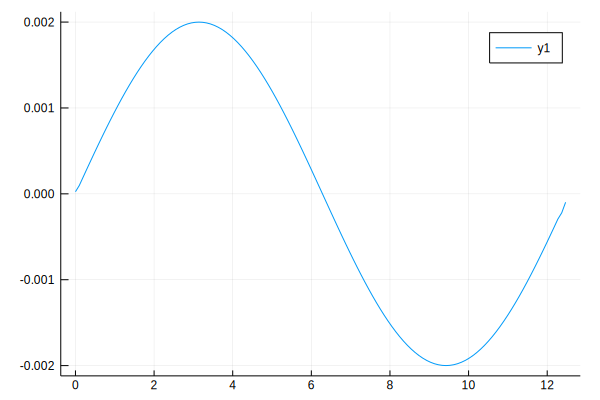

In [13]:
nt = 1000
tf = 100.0
t  = range(0.0, stop=tf, length=nt)
x, e = landau(tf, nt)
plot( x, e)

In [9]:
using Profile

nt = 1000
tf = 100.0
t  = range(0.0, stop=tf, length=nt)
@time nrj = landau(tf, nt)
plot( t, nrj; label = "E")
plot!(t, -0.1533*t.-5.50; label="-0.1533t.-5.5")

MethodError: MethodError: no method matching adjoint(::Type{Poisson})
Closest candidates are:
  adjoint(!Matched::Missing) at missing.jl:79
  adjoint(!Matched::Number) at number.jl:193
  adjoint(!Matched::Adjoint{#s177,#s176} where #s176<:Union{StaticArray{Tuple{N},T,1} where T where N, StaticArray{Tuple{N,M},T,2} where T where M where N} where #s177) at /Users/navaro/.julia/packages/StaticArrays/WmJnA/src/linalg.jl:78
  ...

In [ ]:
using ProfileView
ProfileView.v